### Imports and constants

In [1]:
import math
import numpy as np
import pandas as pd
import shapely
import matplotlib
from matplotlib import pylab as plt
import geopandas as gpd
import pyproj
import contextily as ctx
from time import perf_counter
from copy import deepcopy

from shapely.geometry import Point, LineString, MultiPoint, Polygon, GeometryCollection
from shapely.ops import unary_union, nearest_points
from shapely.wkt import loads as wkt_load

crs_gps = pyproj.CRS.from_epsg('4326') # WGS84 Merkator (degrees)
crs_web = pyproj.CRS.from_epsg('3857') # Pseudo-Merkator (meters)
crs_est = pyproj.CRS.from_epsg('3301') # Estonian Coordinate System

# https://epsg.io/transform#s_srs=4326&t_srs=3301 - used this to convert from gps to estonian coordinate system
# needed to invert latitude and longitude
delta = Point(659351.9779390106, 6474942.48407838)
lounakeskus = Point(656661.9914198933, 6471868.239886967)
sirius = Point(659234.2258483924, 6471525.160984464)
ihaste = Point(663231.1552057452, 6471198.855079322)
kvissental = Point(657392.1712729766, 6477063.679848602)

In [2]:
data = pd.read_csv("data/driveways_cleaned.csv", index_col="global_id")
data["geometry"] = data["geometry"].apply(wkt_load)
gdf_data = gpd.GeoDataFrame(data, geometry="geometry", crs=crs_est)
# Remove 3 instances of MultiLineStrings (they don't allow for coords)
gdf_data = gdf_data[gdf_data.geometry.geom_type == "LineString"]
gdf_data["start_node_x"] = gdf_data.geometry.apply(lambda row: round(row.coords[0][0],3))
gdf_data["start_node_y"] = gdf_data.geometry.apply(lambda row: round(row.coords[0][1],3))
gdf_data["end_node_x"] = gdf_data.geometry.apply(lambda row: round(row.coords[-1][0],3))
gdf_data["end_node_y"] = gdf_data.geometry.apply(lambda row: round(row.coords[-1][1],3))
gdf_data.head()

,directionality,length,speed_limit,geometry,start_node_x,start_node_y,end_node_x,end_node_y
global_id,,,,,,,,
{8F969862-9F81-480E-AB2F-89DF27005924},0.0,30.009882,50.0,"LINESTRING (659566.000 6469788.800, 659568.900...",659566.0,6469788.8,659569.2,6469759.0
{BE820666-6211-42A5-9E93-5C17A9F1D2AC},0.0,11.882761,50.0,"LINESTRING (659564.600 6469800.600, 659566.000...",659564.6,6469800.6,659566.0,6469788.8
{ECAC42D9-5D54-4639-8BC9-63481F9B373A},0.0,48.868986,50.0,"LINESTRING (659564.600 6469800.600, 659583.400...",659564.6,6469800.6,659613.4,6469802.9
{BF989B70-DEF6-4B25-BCC6-80F2C0223549},0.0,35.750524,50.0,"LINESTRING (659562.700 6469836.300, 659564.600...",659562.7,6469836.3,659564.6,6469800.6
{9BB99A5D-705B-40DD-A2A4-44588D20AA9E},0.0,27.115494,50.0,"LINESTRING (659562.700 6469836.300, 659589.700...",659562.7,6469836.3,659589.7,6469838.8


### Edges as a dictionary

In [3]:
from collections import defaultdict
# defaultdict of start nodes that points to a defaultdict of end nodes that points to a tuple that ->
# -> contains the distance of the end node and the global id of the road one should take
graph = defaultdict(lambda: defaultdict( lambda: [math.inf, None]))

for index, row in gdf_data.iterrows():
    # there were 3 lines that were MultiLineString which didn't allow for coords, so I excluded them
    if row.geometry.geom_type != "LineString":
        continue
    start_node = (row.start_node_x, row.start_node_y)
    end_node = (row.end_node_x, row.end_node_y)
    graph[start_node][end_node] = [row.length, index] 
    # if traffic is two-way, need to add an edge from end to beginning
    if row.directionality == 0:
        graph[end_node][start_node] = [row.length, index]

In [39]:
def get_closest_road_idx(point, road_table):
    distances_to_roads = point.distance(road_table["geometry"])
    return distances_to_roads.idxmin()

def get_road_start(road_idx, road_table):
    return (gdf_data.loc[road_idx].start_node_x, gdf_data.loc[road_idx].start_node_y)

def get_road_end(road_idx, road_table):
    return (gdf_data.loc[road_idx].end_node_x, gdf_data.loc[road_idx].end_node_y)

def get_node_idx(node_tuple, nodes):
    for i in range(len(nodes)):
        if nodes[i] == node_tuple:
            return i
    return None

def recreate_path(pn, end):
    prev, road = pn[end]
    roads = [road]
    while pn[prev] != None:
        roads.append(road)
        prev, road = pn[prev]
    roads.reverse()
    return roads

### A star from Dijkstra

In [17]:
def calculate_heuristic(start, end):
    return math.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)

In [42]:
# inspired by https://gist.github.com/qpwo/cda55deee291de31b50d408c1a7c8515
# and https://dzone.com/articles/from-dijkstra-to-a-star-a-part-2-the-a-star-a-algo

from queue import PriorityQueue


def a_star(graph, start, end):
    visited = set()
    cost = {start: 0}
    prev = {start: None}

    pq = PriorityQueue()
    
    g_start = 0
    h_start = calculate_heuristic(start, end)
    f_start = g_start + h_start
    pq.put((f_start, start))

    while pq:
        while not pq.empty():
            _, node = pq.get()
            if node == end:
                break
            if node not in visited:
                break
        if node == end:
            break
        if node in visited:
            break
        visited.add(node)
        for neighbor in graph[node].keys():
            if neighbor in visited:
                continue
            distance, road = graph[node][neighbor]
            old_cost = cost.get(neighbor, math.inf)
            new_g_cost = cost[node] + distance
            new_f_cost = new_g_cost + calculate_heuristic(node, neighbor)
            if new_f_cost < old_cost:
                pq.put((new_f_cost, neighbor))
                cost[neighbor] = new_g_cost
                prev[neighbor] = (node, road)

    return cost, prev

In [43]:
start_dijkstra = perf_counter()
distances, prev_roads = a_star(graph, start, end_lounakeskus)
print(f'Time taken: {perf_counter() - start_dijkstra}')
path_lounakeskus = recreate_path(prev_roads, end_lounakeskus)
path_lounakeskus.insert(0, delta_road)
distances, prev_roads = a_star(graph, start, end_sirius)
path_sirius = recreate_path(prev_roads, end_sirius)
path_sirius.insert(0, delta_road)
distances, prev_roads = a_star(graph, start, end_ihaste)
path_ihaste = recreate_path(prev_roads, end_ihaste)
path_ihaste.insert(0, delta_road)
distances, prev_roads = a_star(graph, start, end_kvissental)
path_kvissental = recreate_path(prev_roads, end_kvissental)
path_kvissental.insert(0, delta_road)

Time taken: 0.07715666700005386


In [31]:
prev, road = prev_roads[end_lounakeskus]

In [27]:
delta_road = get_closest_road_idx(delta, gdf_data)
start = get_road_start(delta_road, gdf_data)
lounakeskus_road = get_closest_road_idx(lounakeskus, gdf_data)
end_lounakeskus = get_road_end(lounakeskus_road, gdf_data)
sirius_road = get_closest_road_idx(sirius, gdf_data)
end_sirius = get_road_end(sirius_road, gdf_data)
ihaste_road = get_closest_road_idx(ihaste, gdf_data)
end_ihaste = get_road_end(ihaste_road, gdf_data)
kvissental_road = get_closest_road_idx(kvissental, gdf_data)
end_kvissental = get_road_end(kvissental_road, gdf_data)

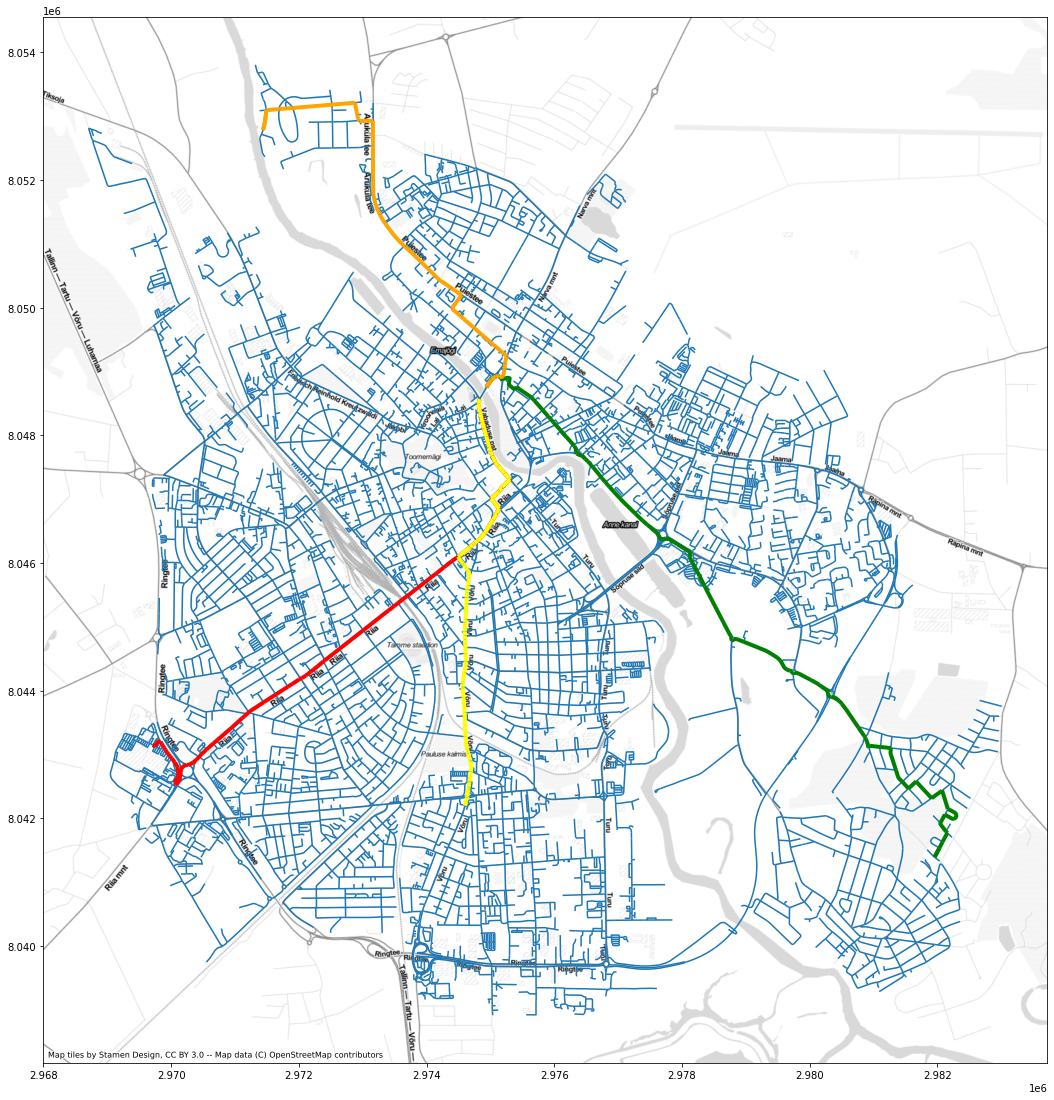

In [44]:
# visualize the path

fig,ax = plt.subplots(1,1, figsize=(18,20))
# Need to change CRS for plotting
gdf_data.to_crs(crs_web).plot(ax=ax)
gdf_data.loc[path_lounakeskus].to_crs(crs_web).plot(ax=ax, color="red", lw=4)
gdf_data.loc[path_sirius].to_crs(crs_web).plot(ax=ax, color="yellow", lw=4)
gdf_data.loc[path_ihaste].to_crs(crs_web).plot(ax=ax, color="green", lw=4)
gdf_data.loc[path_kvissental].to_crs(crs_web).plot(ax=ax, color="orange", lw=4)
ctx.add_basemap(ax=ax, source=ctx.providers.Stamen.TonerLite)